In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [46]:
class SentientAnalizer(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, vocab_size, embedding_dim):
        super(SentientAnalizer, self).__init__()
        """
        [Vocab_size -> Embedding_size]
        input_size: [Seq, Batch, Inputs]
        """
        # input_size == 1
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.Vocab_Embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.LSTM = nn.LSTM(self.embedding_dim, self.hidden_size,num_layers=2, batch_first=True)
        self.Linear1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.Linear2 = nn.Linear(self.hidden_size, self.output_size)


    def forward(self,x, hidden):
        emb = self.Vocab_Embedding(x).view(x.shape[0],x.shape[1],-1)
        #print (emb.shape)
        #print (hidden[0].shape)
        out, hidden = self.LSTM(emb, hidden)
        out = self.Linear1(out)
        out = self.Linear2(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(2, batch_size, self.hidden_size),
                torch.zeros(2, batch_size, self.hidden_size))

In [47]:
class StockPredictor(nn.Module):

    def __init__(self, input_size_stock,input_size_sentiment, hidden_size, num_layers, max_length):
        super(StockPredictor, self).__init__()
        """
        [Vocab_size -> Embedding_size]
        input_size: [Seq, Batch, Inputs]
        """
        # input_size == 1
        self.input_size_stock = input_size_stock
        self.input_size_sentiment = input_size_sentiment
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.attn_hidd = nn.Linear(self.hidden_size, max_length)
        self.attn_out = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.CombinedLayerSS = nn.Linear(self.input_size_stock+self.input_size_sentiment, self.hidden_size)
        self.LSTM = nn.LSTM(self.input_size_sentiment+self.input_size_stock, self.hidden_size,num_layers=num_layers, batch_first=True)
        self.Linear1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.Linear2 = nn.Linear(self.hidden_size, self.input_size_stock)


    def forward(self,x, hidden, stock_news):
        attn_wights = F.softmax(self.attn_hidd(hidden[0][0]), dim=1)
        context = torch.bmm(attn_wights.unsqueeze(0), stock_news.unsqueeze(0))
        x_SS = torch.cat((x,context),dim=2)
        out, hidden = self.LSTM(x_SS, hidden)
        out = self.Linear1(out)
        out = self.Linear2(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))

In [48]:
news_1 = pd.read_csv('../data/Preprocess/final_data/Crypto_Currency_News.csv') # news_np[0]
news_2 = pd.read_csv('../data/Preprocess/final_data/CryptoCurrencies.csv') # news_np[1]
news_3 = pd.read_csv('../data/Preprocess/final_data/CryptoCurrency.csv') # news_np[2]
news_4 = pd.read_csv('../data/Preprocess/final_data/Cryptomarkets.csv') # news_np[3]
news_5 = pd.read_csv('../data/Preprocess/final_data/eth.csv') # news_np[4]
news_6 = pd.read_csv('../data/Preprocess/final_data/ethfinance.csv') # news_np[5]
news_7 = pd.read_csv('../data/Preprocess/final_data/ethtrader.csv') # news_np[6]

stocks_norm = pd.read_csv('../data/Preprocess/final_data/finance_norm.csv')


news_dfs = [news_1, news_2, news_3, news_4, news_5, news_6, news_7]

# import scaler
with open('../data/Preprocess/scaler.pkl', 'rb') as f:
    scaler = pkl.load(f)

In [49]:
news_1.head(1)

,date,tok_text_1,tok_text_2,tok_text_3,tok_text_4,tok_text_5,tok_text_6,tok_text_7,tok_text_8,tok_text_9,tok_text_10
0,1/10/2019,"[1, 60, 61, 62, 63, 64, 65, 66, 67, 60, 63, 62...","[1, 93, 94, 60, 95, 96, 60, 84, 97, 98, 99, 10...","[1, 110, 111, 112, 113, 114, 84, 19, 56, 115, ...","[1, 120, 121, 43, 122, 123, 124, 125, 67, 126,...","[1, 5, 10, 127, 129, 119, 67, 130, 131, 132, 1...","[1, 136, 137, 138, 139, 140, 141, 2, 0, 0, 0, ...","[1, 142, 143, 144, 145, 2, 0, 0, 0, 0, 0, 0, 0...","[1, 147, 148, 149, 67, 126, 150, 2, 151, 2, 0,...","[1, 29, 152, 153, 154, 2, 0, 0, 0, 0, 0, 0, 0,...","[1, 13, 155, 49, 84, 156, 2, 0, 0, 0, 0, 0, 0,..."


In [50]:
'''
example of cell in news_1:
'[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]'
is saved as a string
'''
# change type
import ast
for df in news_dfs:
    for j in range(1,11):        
        df['tok_text_'+str(j)] = np.array(df['tok_text_'+str(j)].apply(lambda x: ast.literal_eval (x)))

In [51]:
# convert all dataframes to numpy
# news_1_np = news_1.to_numpy()
news_np = []
for df in news_dfs:
    news_np.append(df.to_numpy())

stocks_norm_np = stocks_norm.to_numpy()

# delete 1st column
# news_1_np = news_1_np[:,1:]
for i in range(len(news_np)):
    news_np[i] = np.delete(news_np[i], 0, 1)
stocks_norm_np = stocks_norm_np[:,1:]

# reshape from (n,10) lists to (n,10,15) numbers
for k in range(len(news_np)):
    news_np[k] = np.array([np.array([np.array(news_np[k][i][j]) for j in range(10)]) for i in range(news_np[k].shape[0])])

# print
for i in range(len(news_np)):
    print(news_np[i].shape)
print (stocks_norm_np.shape)
# print first a row, already checked it is the first row from the CSVs
# print (news_np[0][0])
# print(stocks_norm_np[0])

(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 10, 15)
(1096, 9)


In [52]:
# shape dataset to pytorch dataset class    
class Dataset (torch.utils.data.Dataset):
    def __init__(self, data_stock, notice, target):
        self.data = data_stock.unsqueeze(1)
        self.notice = notice.unsqueeze(3)
        self.target = target.unsqueeze(1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.notice[idx], self.target[idx]

# using news_1 and stocks_norm
data_stock = torch.Tensor(stocks_norm_np[:,:]).float()
data_news = torch.Tensor(news_np[0]).long() # news_np[0] is news_1 (Crypto_Currency_News.csv), change to others for analysis
target = data_stock[1:,:]
data_stock = data_stock[:-1,:]
print (data_stock.shape, data_news.shape, target.shape)

# create dataset
dataset = Dataset(data_stock, data_news, target)

torch.Size([1095, 9]) torch.Size([1096, 10, 15]) torch.Size([1095, 9])


In [53]:
Senti = SentientAnalizer(1, 128, 256, 50000, 128) # 50000 is the size of the vocabulary, our dictionary has 49783 words
Stock = StockPredictor(9,256,256,9,10) # 9 is the number of variables in the stock

In [54]:
# dataloader
train_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

In [55]:
# optimizer
optimizer = torch.optim.Adam(list(Senti.parameters())+list(Stock.parameters()), lr=0.001)
# loss function
criterion = nn.MSELoss()

In [56]:

# test the dataloader
# for i, (data_stock, data_news, target) in enumerate(train_loader):
#     print (data_stock.shape, data_news.shape, target.shape)
#     # Test the model
#     data_news = data_news.squeeze(0)
#     hidde_senti = Senti.init_hidden(data_news.shape[0])
#     out_senti, hidden_senti = Senti(data_news, hidde_senti)
#     out_senti = out_senti[:,-1,:]
#     hidde_stock = Stock.init_hidden(data_stock.shape[0])
#     out_stock, hidden_stock = Stock(data_stock, hidde_stock, out_senti)
#     print (out_stock.shape)
#     # Test the optimizer
#     optimizer.zero_grad()
#     loss = criterion(out_stock, target)
#     print(loss.item())
#     loss.backward()
#     optimizer.step()
#     break

In [57]:
# Test predict the next 5 days
# for i in range(5):    
#     out_stock, hidden_stock = Stock(out_stock, hidde_stock, out_senti)
#     print (out_stock.shape)

In [58]:
# train
epochs = 1 # 50 is overkill, do what you want
# array to store predictions
preds = []
for epoch in range(epochs):
    epoch_loss = 0
    e_preds = []
    hidde_senti = Senti.init_hidden(10)
    hidde_stock = Stock.init_hidden(1)
    print('-- Epoch', epoch+1, '--')
    for i, (data_stock, data_news, target) in enumerate(train_loader):
        data_news = data_news.squeeze(0)
        out_senti, hidden_senti = Senti(data_news, hidde_senti)
        out_senti = out_senti[:,-1,:]
        out_stock, hidden_stock = Stock(data_stock, hidde_stock, out_senti)
        # store predictions
        e_preds.append(out_stock)
        # optimizer
        optimizer.zero_grad()   
        loss = criterion(out_stock, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        if i % 200 == 0: # 1096 steps
            print('Step:', i, ' Loss:', epoch_loss/(i+1))
            # print (i, epoch_loss/(i+1))
    preds.append(e_preds)
    print(epoch+1, '/', epochs, 'completed')
    print (epoch+1, 'Final Loss:', epoch_loss/(i+1), '\n')


-- Epoch 1 --
Step: 0  Loss: 0.06200883910059929
Step: 200  Loss: 0.0032328592227967063
Step: 400  Loss: 0.002052121144273012
Step: 600  Loss: 0.0052074301121348325
Step: 800  Loss: 0.004960724368624489
Step: 1000  Loss: 0.004736543492431887
1 / 1 completed
1 Final Loss: 0.004599128929535109 



In [59]:
# make preds to numpy
preds_mod = torch.cat(preds[-1], dim=0)
# cant use preds = preds.detach().numpy() due to version issues, workaround:
preds_mod = preds_mod.tolist()
preds_np = np.array(preds_mod)
preds_np = np.squeeze(preds_np, axis=1)
print (preds_np.shape)
print (stocks_norm_np.shape)

(1095, 9)
(1096, 9)


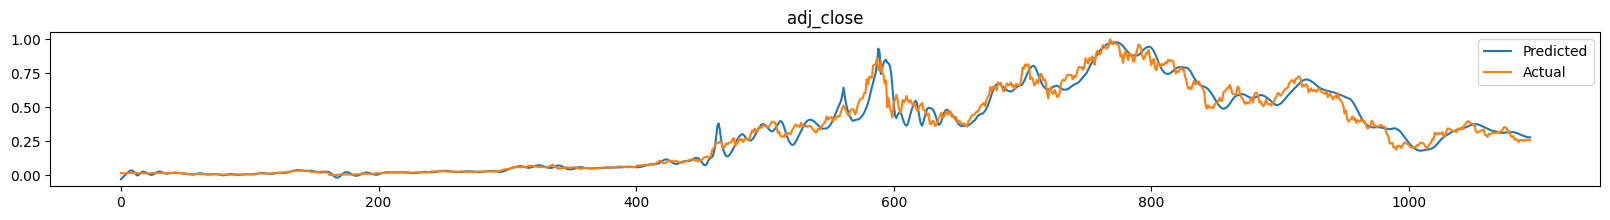

Last 5 predictions: 0.28555, 0.28248, 0.28028, 0.27917, 0.27859
Last 5 actual: 0.26050, 0.25939, 0.26094, 0.26057, 0.25893


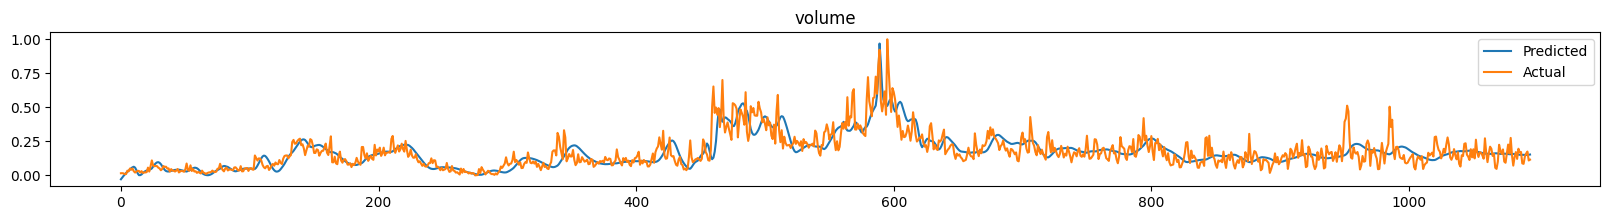

Last 5 predictions: 0.15004, 0.14968, 0.15008, 0.15153, 0.15299
Last 5 actual: 0.13765, 0.16078, 0.17494, 0.10946, 0.11516


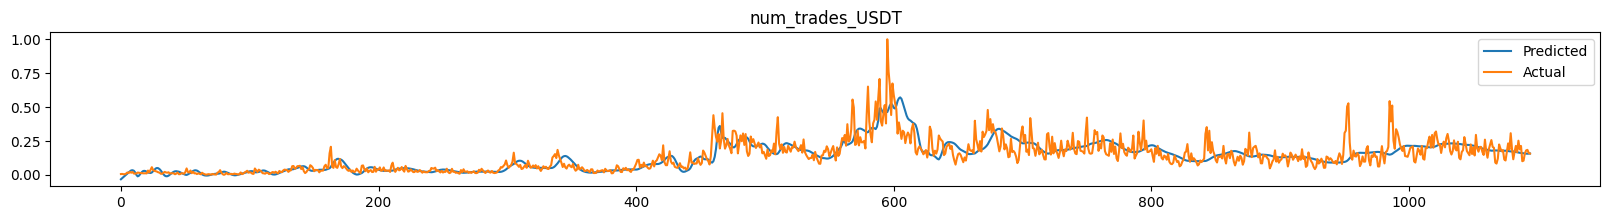

Last 5 predictions: 0.15770, 0.15641, 0.15587, 0.15618, 0.15693
Last 5 actual: 0.15851, 0.18059, 0.18428, 0.16149, 0.15720


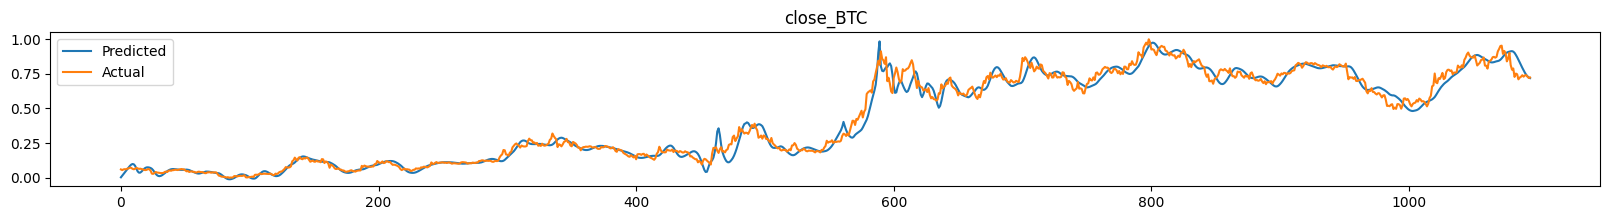

Last 5 predictions: 0.75862, 0.74382, 0.73240, 0.72475, 0.71944
Last 5 actual: 0.73908, 0.74055, 0.73028, 0.72041, 0.72359


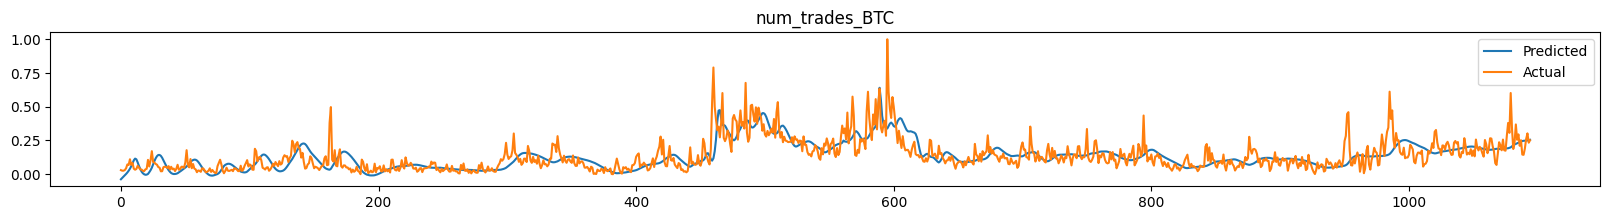

Last 5 predictions: 0.24833, 0.24884, 0.25001, 0.25240, 0.25495
Last 5 actual: 0.19015, 0.26098, 0.30274, 0.23348, 0.25147


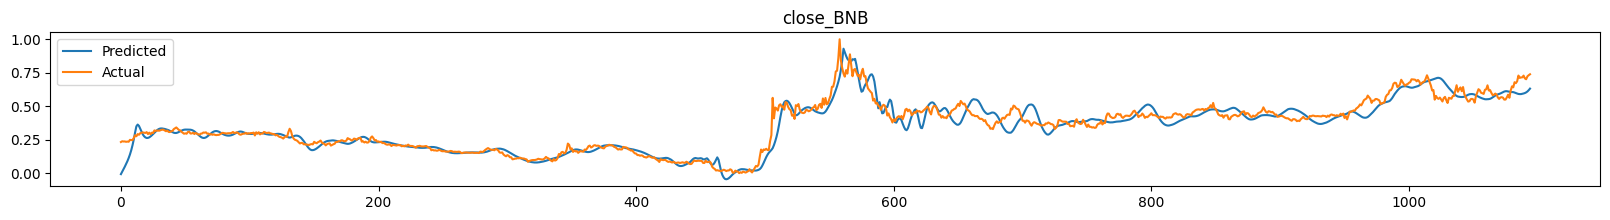

Last 5 predictions: 0.59842, 0.60324, 0.61019, 0.62002, 0.63147
Last 5 actual: 0.70773, 0.70131, 0.72336, 0.73178, 0.73860


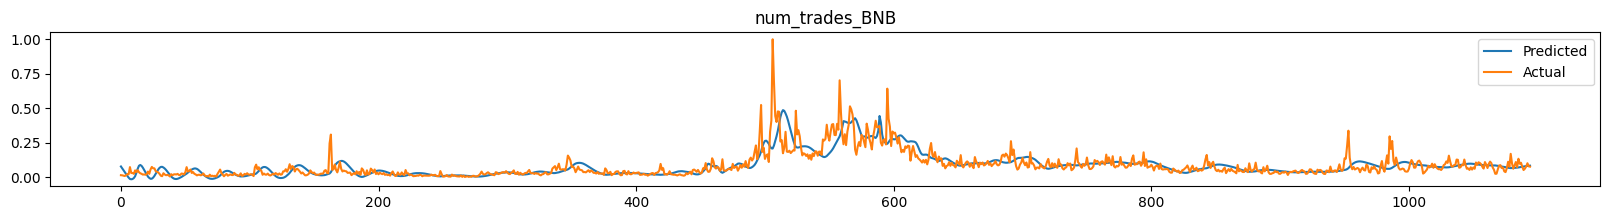

Last 5 predictions: 0.07800, 0.07900, 0.07988, 0.08094, 0.08187
Last 5 actual: 0.05985, 0.07570, 0.09955, 0.07690, 0.07491


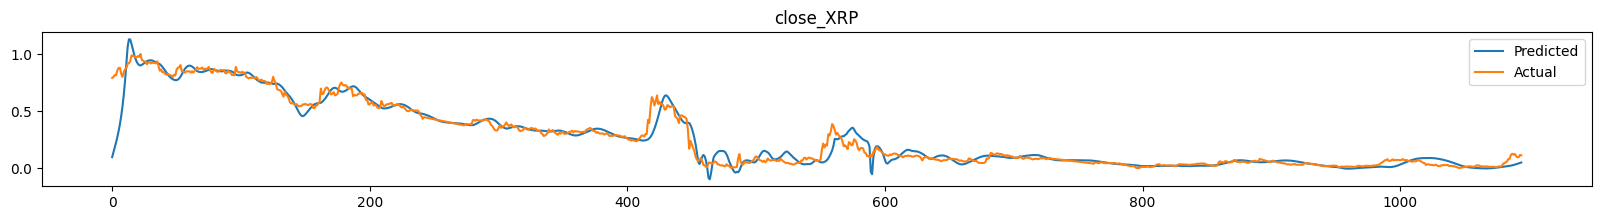

Last 5 predictions: 0.03373, 0.03743, 0.04116, 0.04488, 0.04882
Last 5 actual: 0.10482, 0.09517, 0.09543, 0.11448, 0.11193


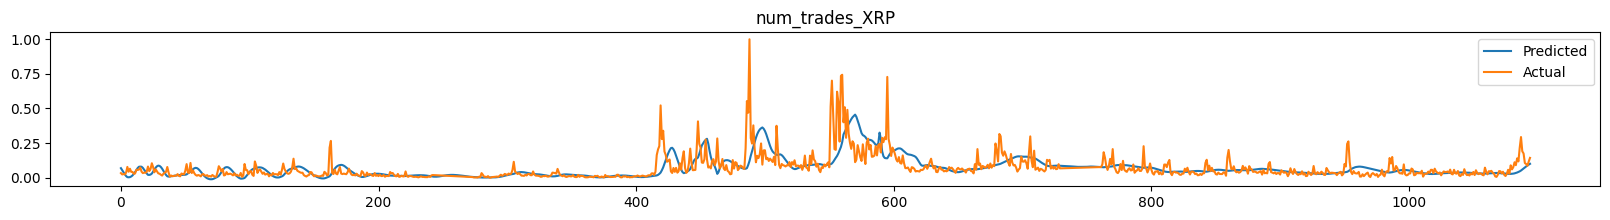

Last 5 predictions: 0.07449, 0.08168, 0.08830, 0.09434, 0.10001
Last 5 actual: 0.10567, 0.09867, 0.08562, 0.11665, 0.14292


In [60]:
# graph predictions vs actual
# stocks_norm_np has 9 columns
table_names = ['adj_close','volume','num_trades_USDT','close_BTC','num_trades_BTC','close_BNB','num_trades_BNB','close_XRP','num_trades_XRP']
for i in range(9):
    plt.figure(figsize=(20,2))
    plt.plot(preds_np[:,i], label='Predicted')
    plt.plot(stocks_norm_np[1:,i], label='Actual')
    plt.legend()
    plt.title(table_names[i])
    plt.show()
    print ('Last 5 predictions: %.5f, %.5f, %.5f, %.5f, %.5f' % (preds_np[-5,i], preds_np[-4,i], preds_np[-3,i], preds_np[-2,i], preds_np[-1,i]))
    print ('Last 5 actual: %.5f, %.5f, %.5f, %.5f, %.5f' % (stocks_norm_np[-5,i], stocks_norm_np[-4,i], stocks_norm_np[-3,i], stocks_norm_np[-2,i], stocks_norm_np[-1,i]))


In [61]:
# print data
print (out_stock)
print (target)

tensor([[[0.2786, 0.1530, 0.1569, 0.7194, 0.2550, 0.6315, 0.0819, 0.0488,
          0.1000]]], grad_fn=<ViewBackward0>)
tensor([[[0.2589, 0.1152, 0.1572, 0.7236, 0.2515, 0.7386, 0.0749, 0.1119,
          0.1429]]])


In [67]:
# save model just in case
torch.save(Senti.state_dict(), 'saved_models/Senti_23_04.pth')
torch.save(Stock.state_dict(), 'saved_models/Stock_23_04.pth')

In [63]:
out_stock_n = out_stock.tolist()
target_n = target.tolist()
out_stock_n = out_stock_n[0][0]
target_n = target_n[0][0]

In [64]:
# unnormalize the data using loaded scaler
out_stock_n = scaler.inverse_transform([out_stock_n])
target_n = scaler.inverse_transform([target_n])

print (out_stock_n)
print (target_n)

[[1.42041246e+03 1.72520995e+10 9.25445427e+05 6.81197830e-02
  3.49590704e+05 1.87576557e-01 3.12609577e+04 2.64341482e-04
  1.51795772e+04]]
[[1.32797869e+03 1.42501004e+10 9.26935015e+05 6.84120008e-02
  3.45606986e+05 2.14300002e-01 2.88649999e+04 3.61100005e-04
  2.12500005e+04]]


In [65]:
# o para ver bonito
df_out = pd.DataFrame(out_stock_n[0])
df_target = pd.DataFrame(target_n[0])
df_out = df_out.T
df_target = df_target.T
df_out.columns = ['adj_close','volume','num_trades_USDT','close_BTC','num_trades_BTC','close_BNB','num_trades_BNB','close_XRP','num_trades_XRP']
df_target.columns = ['adj_close','volume','num_trades_USDT','close_BTC','num_trades_BTC','close_BNB','num_trades_BNB','close_XRP','num_trades_XRP']
df_out.head()

,adj_close,volume,num_trades_USDT,close_BTC,num_trades_BTC,close_BNB,num_trades_BNB,close_XRP,num_trades_XRP
0,1420.41246,1.725210e+10,925445.42691,0.06812,349590.703703,0.187577,31260.957653,0.000264,15179.577243


In [66]:
df_target.head()

,adj_close,volume,num_trades_USDT,close_BTC,num_trades_BTC,close_BNB,num_trades_BNB,close_XRP,num_trades_XRP
0,1327.978689,1.425010e+10,926935.014897,0.068412,345606.9856,0.2143,28864.999861,0.000361,21250.000517
